# 군집화

## K-평균 알고리즘

군집 중심점(centroid)이라는 특정한 임의의 지점을 선택해 해당 중심에 가까운 포인트를 선택, 다시 중심점을 평균 지점으로 이동하는
프로세스를 반복적으로 수행한다. 모든 데이터 포인트에서 더이상 중심점의 이동이 없을 경우에 반복을 멈추고 해당 중심점에 속하는 데이터 포인트들을 군집화하는 기법이다.



![kmeans](./pictures/kmeans.png)

#### 장점

- 일반적인 군집화에서 가장 많이 활용하는 알고리즘
- 알고리즘이 쉽고 간결

#### 단점

- 거리 기반 알고리즘으로 속성의 개수가 많을 경우 군집화 정확도가 떨어진다. (이를 위해 PCA를 적용해야 할 수도 있음)
- 반복을 수행하는데, 반복 횟수가 많을 경우 수행 시간이 느려짐
- 몇 개의 군집(cluster)을 선택해야 할지 가이드하기가 어렵다.

In [2]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

iris=load_iris()

In [3]:
iris_df=pd.DataFrame(data=iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
kmeans=KMeans(n_clusters=3, max_iter=300, random_state=0).fit(iris_df)

In [5]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [7]:
iris_df['cluster']=kmeans.labels_
iris_df['target']=iris.target

In [9]:
iris_result=iris_df.groupby(['target','cluster'])['sepal_length'].count()
iris_result

target  cluster
0       1          50
1       0          48
        2           2
2       0          14
        2          36
Name: sepal_length, dtype: int64

시각화

In [10]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca_transformed=pca.fit_transform(iris.data)

iris_df['pca_x']=pca_transformed[:,0]
iris_df['pca_y']=pca_transformed[:,1]
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,cluster,target,pca_x,pca_y
0,5.1,3.5,1.4,0.2,1,0,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,1,0,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,1,0,-2.888991,-0.144949
3,4.6,3.1,1.5,0.2,1,0,-2.745343,-0.318299
4,5.0,3.6,1.4,0.2,1,0,-2.728717,0.326755


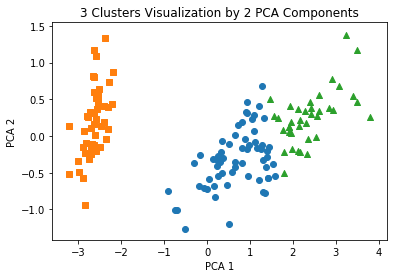

In [11]:
marker0=iris_df[iris_df['cluster']==0].index
marker1=iris_df[iris_df['cluster']==1].index
marker2=iris_df[iris_df['cluster']==2].index

plt.scatter(x=iris_df.loc[marker0,'pca_x'], y=iris_df.loc[marker0,'pca_y'], marker='o')
plt.scatter(x=iris_df.loc[marker1,'pca_x'], y=iris_df.loc[marker1,'pca_y'], marker='s')
plt.scatter(x=iris_df.loc[marker2,'pca_x'], y=iris_df.loc[marker2,'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

## 군집 평가

### 실루엣 분석 (silhouette analysis)

실루엣 계수 (silhouette coefficient)를 기반으로 평가. 각 군집간의 거리가 멀고, 군집 내의 데이터가 잘 모여있는지 평가

0~1 사이의 값을 가지며, 1에 가까울 수록 좋다.

전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값의 편차가 크지 않아야한다.
즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요하다.
만약 전체 실루엣 계수의 평균값은 높지만, 특정 군집의 실루엣 계수의 평균값만 유난히 높고 다른 군집들의 실루엣 평균값은 낮으면
좋은 군집화 조건이 아니다.

In [12]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score # 군집 평가를 위한 metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()

In [13]:
feature_names=['sepal_length','sepal_width','petal_length','petal_width']

iris_df=pd.DataFrame(data=iris.data, columns=feature_names)

In [14]:
kmeans=KMeans(n_clusters=3, init='k-means++',max_iter=300, random_state=0).fit(iris_df)

iris_df['cluster']=kmeans.labels_

In [17]:
# iris의 모든 개별 데이터에 실루엣 계수 값을 구함

score_samples=silhouette_samples(iris.data, iris_df['cluster'])
print('silhouette_samples() return 값의 shape', score_samples.shape)

silhouette_samples() return 값의 shape (150,)


In [18]:
iris_df['silhouette_coeff']=score_samples

In [19]:
average_score=silhouette_score(iris.data, iris_df['cluster'])
print('붓꽃 데이터 세트 Silhouette Analysis Score : {0:.3f}'.format(average_score))
iris_df.head()

붓꽃 데이터 세트 Silhouette Analysis Score : 0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315
3,4.6,3.1,1.5,0.2,1,0.805014
4,5.0,3.6,1.4,0.2,1,0.849302


평균 실루엣 계수 값이 약 0.553 임을 볼 수 있다.

In [20]:
iris_df.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

1번 군집은 실루엣 계수 평균 값이 약 0.79인데 반해, 0번과 2번은 각 0.41, 0.45로 상대적으로 
평균값이 1번보다 낮다.

#### 시각화를 통한 군집 개수 최적화 방법

KMeans 클래스는 n_init 횟수만큼 반복하여 최상의결과를 만드는 중심 포인트를 찾는다.

n_init 의 기본값은 10이고 비교하는 기준은 샘플과 클러스터 중심까지의 거리 합이다.

이를 이너셔(inertia) 라고 부르며 inertia_ 속성에 저장되어 있다

C:\Users\river\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


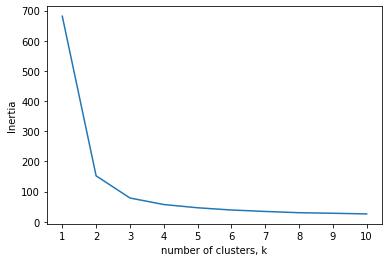

In [24]:
ks=list(range(1,11))
inertias=list()

for k in ks:
    kmeans=KMeans(n_clusters=k, max_iter=300, random_state=0).fit(iris.data)
    inertias.append(kmeans.inertia_)
    
plt.plot(ks, inertias)
plt.xlabel('number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

3 -> 4 로 k 값이 증가한 이후로 이너셔 값의 변동이 미비하므로

적절한 군집의 개수는 3~4개로 설정하는 것이 좋다.

## 평균 이동 (Mean shift)

K-평균이 중심에 소속된 데이터의 평균 거리 중심으로 이동하는 데 반해, 평균이동은 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킨다.

평균 이동은 데이터의 분포도를 이용해 군집 중심점을 찾는다. 군집 중심점은 데이터 포인트가 모여 있는 곳이라는 생각에서 착안한 것이며 이를 위해 확률 밀도 함수 (probability density function)를 이용한다.

#### 장점

- 평균 이동은 K-평균과 다르게 군집의 개수를 지정할 필요가 없다. 대역폭의 크기에 따라 알고리즘 자체에서 군집의 개수를 최적으로 정한다.
- 데이터 세트의 형태를 특정 형태로 가정한다던가, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화가 가능하다.
- 이상치의 영량력이 크지않다.


#### 단점

- 대역폭 크기를 어떤 값으로 설정하는가에 따라 군집화의 품질이 결정된다.
- 알고리즘의 수행 시간이 오래 걸린다.

In [28]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs

In [29]:
X, y =make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)

In [30]:
X.shape

(200, 2)

In [31]:
y.shape

(200,)

In [34]:
meanshift=MeanShift(bandwidth=0.9)

cluster_labels=meanshift.fit_predict(X)
print('Cluster labels 유형 : ',np.unique(cluster_labels))

Cluster labels 유형 :  [0 1 2 3 4 5 6 7]


bandwidth를 0.9로 설정하였을 때, 군집이 8개로 분류됐음을 볼 수 있다.

일반적으로 bandwidth 값을 작게 할수록 군집 개수가 많아진다.

In [35]:
meanshift=MeanShift(bandwidth=1)

cluster_labels=meanshift.fit_predict(X)
print('Cluster labels 유형 : ', np.unique(cluster_labels))

Cluster labels 유형 :  [0 1 2]


사이킷런은 최적화된 bandwidth 값을 찾기 위해서 estimate_bandwidth()를 제공한다.

estimate_bandwidth()의 파라미터로 피처 데이터 세트를 입력하면 최적화된 bandwidth 값을 반환해준다.

In [36]:
from sklearn.cluster import estimate_bandwidth

bandwidth=estimate_bandwidth(X, quantile=0.2)
print('bandwidth 값 : ',round(bandwidth, 3))

bandwidth 값 :  1.444


estimate_bandwidth()는 내부적으로 kernel bandwidth를 정하기 위해 KNN 기법을 이용한다.

이때 KNN을 수행하는 데이터의 건수를 전체 데이터 * quantile 로 정한다. 전체 데이터가 100건이고 quantile=0.3 이면
30건을 대상으로 KNN으로 클러스터링을 수행한다. 이후 같은 클러스터 내의 데이터간 평균 거리(average pairwise distances) 를 기반으로 bandwidth를 정한다.

일반적으로 quantile이 크면 bandwidth 값이 커져서 Mean Shift의 클러스터 개수가 작아지고,
quantile이 작으면 bandwidth 값이 작아져서 Mean Shift의 클러스터 개수가 많아진다.

In [37]:
import pandas as pd

cluster_df=pd.DataFrame(data=X, columns=['ftr1','ftr2'])
cluster_df['target']=y

In [38]:
cluster_df.head()

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0
3,-1.448724,3.384245,2
4,1.214861,5.364896,0


In [40]:
best_bandwidth=estimate_bandwidth(X,quantile=0.2)

meanshift=MeanShift(bandwidth=best_bandwidth)
cluster_labels=meanshift.fit_predict(X)
print('cluster labels 유형 : ',np.unique(cluster_labels))

cluster labels 유형 :  [0 1 2 3]


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

cluster_df['meanshift_labels']=cluster_labels

centers=meanshift.cluster_centers_
unique_labels=np.unique(cluster_labels)

In [43]:
centers # 중심값 좌표

array([[ 1.82056298,  0.76901053],
       [-1.65887009,  2.7799957 ],
       [ 0.90876037,  4.44560153],
       [-0.39007101,  3.69917003]])

In [49]:
cluster_df.head()

,ftr1,ftr2,target,meanshift_labels
0,-1.692427,3.622025,2,1
1,0.697940,4.428867,0,2
2,1.100228,4.606317,0,2
3,-1.448724,3.384245,2,1
4,1.214861,5.364896,0,2


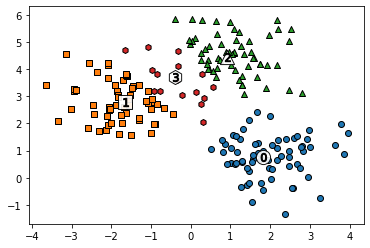

In [47]:
markers=['o','s','^','h','x']

for label in unique_labels:
    label_cluster=cluster_df[cluster_df['meanshift_labels']==label]
    center_x_y=centers[label]
    
    # 군집별로 다른 marker 로 scatter plot 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])
    
    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white', edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',  marker='$%d$' % label)
    
plt.show()

In [51]:
print(cluster_df.groupby('target')['meanshift_labels'].value_counts())

target  meanshift_labels
0       2                   59
        3                    8
1       0                   67
2       1                   58
        3                    8
Name: meanshift_labels, dtype: int64


## GMM (Gaussian Mixture Model)

GMM 군집화는 군집화를 적용하고자 하는 데이터를 가우시안 분포를 적용하여 군집을 판단하는 방식이다.

In [52]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()

In [53]:
feature_names=['sepal_length','sepal_width','petal_length','petal_width']

iris_df=pd.DataFrame(data=iris.data, columns=feature_names)
iris_df['target']=iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [54]:
from sklearn.mixture import GaussianMixture

gmm=GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels=gmm.predict(iris.data)

iris_df['gmm_cluster']=gmm_cluster_labels

In [55]:
gmm_cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [60]:
iris_result=iris_df.groupby(['target'])['gmm_cluster'].value_counts()
iris_result

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64

In [62]:
kmeans=KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels=kmeans.predict(iris.data)

iris_df['kmeans_cluster']=kmeans_cluster_labels

iris_result=iris_df.groupby('target')['kmeans_cluster'].value_counts()
iris_result

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64

K-평균 알고리즘은 데이터가 원형으로 흩어져 있을 때 더 좋은 성능을 발휘한다.

## DBSCAN

특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 사용하여 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 군집화를 잘 수행한다.

In [63]:
from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels=dbscan.fit_predict(iris.data)

iris_df['dbscan_cluster']=dbscan_labels

iris_result=iris_df.groupby('target')['dbscan_cluster'].value_counts()
iris_result

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64

군집 레이블이 -1 인것은 노이즈에 속하는 군집을 의미한다.

따라서 위 붓꽃 데이터 세트는 2개의 군집으로 군집화 되었다.

---

DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미하다고 할 수 있다.

#### 복잡한 기하학적 분포를 가지는 데이터 세트에서 DBSCAN의 성능 확인하기

In [64]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

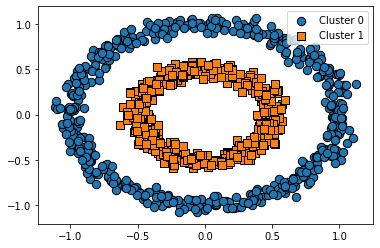

In [65]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5) # factor : 내부원과 외부원의 scale 비율

cluster_df=pd.DataFrame(data=X, columns=['ftr1','ftr2'])
cluster_df['target']=y

visualize_cluster_plot(None, cluster_df, 'target', iscenter=False)

KMeans 의 군집 수행 결과 확인

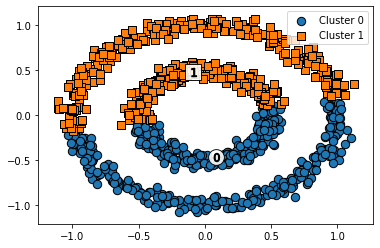

In [66]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels=kmeans.fit_predict(X)

cluster_df['kmeans_cluster']=kmeans_labels

visualize_cluster_plot(kmeans, cluster_df, 'kmeans_cluster', iscenter=True)

위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화됐다.

거리 기반 군집화로는 위와 같이 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾아내기 어렵다.

GMM 의 군집 수행 결과 확인

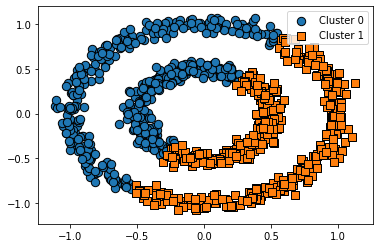

In [67]:
from sklearn.mixture import GaussianMixture

gmm=GaussianMixture(n_components=2, random_state=0)
gmm_label=gmm.fit(X).predict(X)

cluster_df['gmm_cluster']=gmm_label

visualize_cluster_plot(gmm, cluster_df, 'gmm_cluster', iscenter=False)

효과적으로 수행되지 않음

DBSCAN의 군집 수행 결과 확인

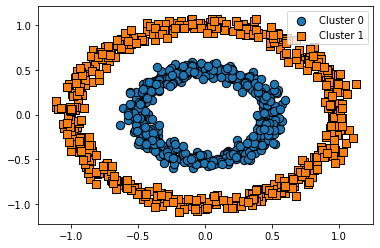

In [68]:
from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels=dbscan.fit_predict(X)

cluster_df['dbscan_cluster']=dbscan_labels

visualize_cluster_plot(dbscan, cluster_df, 'dbscan_cluster', iscenter=False)

DBSCAN으로 군집화를 적용해 원하는 방향으로 정확히 군집화를 수행하였다